# Learning from cannon trajectories: Deterministic example
One day for no particular reason you take your cannon and go to the park to shoot off some cannonballs.  You can control the launch angle, $\theta_0$ and the launch velocity, $v_0$ of each shot.  On top of that, the wind is blowing and your shots will be affected by wind resistance.  But, your cannon is very unsteady and wobbles constantly, randomly varying the initial velocity and angle of each shot.  Plus because the wind is randomly blowing, wind resistance varies each time you shoot a new cannonball.

Your friend is standing (well downrange!) and can measure the trajectory of each shot -- it's vertical and horizontal distance traveled at each point in time.  Because of the random variation affecting the cannon each time you fire, each trajectory will be slightly different.  Can your friend infer the average value of the launch angle, velocity, and the wind resistance by observing enough shots?

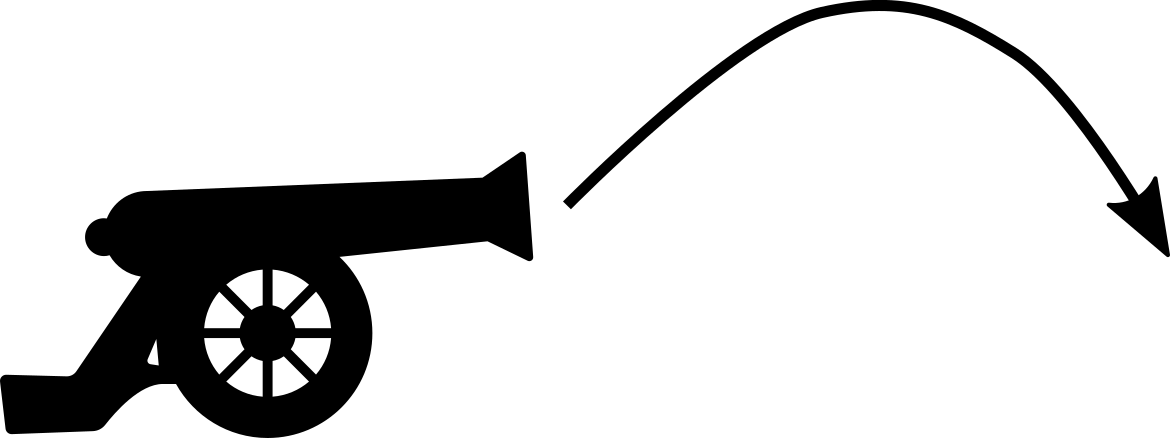

## First grab the packages we need

We'll also set a default tensor type.

In [1]:
# Setup what we need
import sys
sys.path.append('../..')

import matplotlib.pyplot as plt
import tqdm

import torch
torch.manual_seed(62)
torch.set_default_dtype(torch.float64)

from pyzag import ode, nonlinear

## Define the model
Our model can be defined as a system of ordinary differential equations of the form
$$ \dot{v} = h - c v$$
and
$$ \dot{z} = v $$

where $v$ is a vector of two components containing the x and y velocity of the cannonball, $z$ is a vector giving the position of the ball, $h$ is a vector defining graviational acceleration, and $c$ is a constant related to the wind resistance experienced by the ball in flight.  We can expand this vector description into explicit equations for the $x$ and $y$ components of the velocity:
$$ \begin{bmatrix}
\dot{v}_x\\ 
\dot{v}_y
\end{bmatrix}
=
\begin{bmatrix}
0 \\ 
-g
\end{bmatrix}
-
c
\begin{bmatrix}
v_x \\ 
v_y
\end{bmatrix} $$
where $g$ is now the regular scalar gravitational acceleration.

We can trivially do this for the position as well:
$$ \begin{bmatrix}
\dot{z}_x\\ 
\dot{z}_y
\end{bmatrix}
=
\begin{bmatrix}
v_x \\ 
v_y
\end{bmatrix} $$

In addition, we need initial conditions for the velocities, which we can define as:
$$ \begin{bmatrix}
v_x \\ 
v_y
\end{bmatrix} =
 \begin{bmatrix}
v_0 \cos \theta_0 \\ 
v_0 \sin \theta_0
\end{bmatrix} $$
where $\theta_0$ is the cannon launch angle and $v_0$ is the magnitude of the scalar launch velocity.  We will let the position of the cannon be zero, i.e. $z(0) = 0$.

### Rate form
In pyzag we can split the definition of the model into a couple of parts.  The first is just the mathematical definition of the ODE.  We need to define this as the full system of four ODEs, two equations each for the velocity and the position.  We'll call this full system of equations $\dot{s}$ where $s$ is a vector given by
$$ s =
\begin{bmatrix}
v_x \\ 
v_y \\
z_x \\
z_y 
\end{bmatrix} $$

In addition to implementing the rate form of the equations we defined above, we also need to define the Jacobian, given by
$$
J = \frac{d \dot{s}}{d s}
$$
and return this value, along with the actual equations, as part of the `forward` operator.  The reason we need the Jacobian is explained in the next cell.

In [2]:
# Define the rate form of the model
class CannonRateForm(torch.nn.Module):
    """ODE equations defining the canon trajectories
    """
    def __init__(self, c, g, theta0, v0):
        super().__init__()
        self.c = torch.nn.Parameter(c)
        self.h = torch.tensor([0,-g])
        self.theta0 = torch.nn.Parameter(theta0)
        self.v0 = torch.nn.Parameter(v0)

    def forward(self, t, s):
        """Rate form and Jacobian of the model

        Args:
            t (torch.tensor): time (not actually used in this example!)
            s (torch.tensor): concatenated velocity and position vectors

        Returns:
            s_dot (torch.tensor): the state rate, i.e. the rate of change of velocity and position
            J (torch.tensor): the derivative of the state rate with respect to the state, i.e. the velocity and position.
        """
        v = s[...,:2]
        # Define the rate form
        v_dot = self.h - self.c * v
        s_dot = torch.cat([v_dot, v], dim = -1)
        # Define the Jacobian
        I = torch.eye(2, device = s.device).expand(v.shape + (2,))
        zero = torch.zeros_like(I)
        Jvv = - self.c.unsqueeze(-1) *  I
        Jzv = I

        J = torch.cat([torch.cat([Jvv, zero], dim = -1), torch.cat([Jzv, zero], dim = -1)], dim = -2)

        return s_dot, J

    def y0(self, tshape):
        """Define the model initial conditions
        """
        z = torch.zeros_like(self.theta0)
        y0 = (self.v0 * torch.cat([torch.cos(self.theta0), torch.sin(self.theta0), z, z], dim = -1)).expand(tshape + (4,))
        return y0

We will be changing these values a lot below, but let's define the model with some reasonable values for the parameters $c$, $\theta_0$, and $v_0$ and give a value for the gravitational acceleration:

In [3]:
c = torch.tensor([1.0])
g = torch.tensor([1.0])
theta0 = torch.tensor([torch.pi / 4])
v0 = torch.tensor([1.0])
rate_model = CannonRateForm(c, g, theta0, v0)

### Discrete equation
Next we need to apply a numerical time integration scheme to this ODE so that we end up with a discrete (generally) nonlinear system of equations.  We'll use the Backward Euler scheme here, which will transform the ODE into an implicit system of algebraic equations we need to solve to find the next set of velocities and positions as we march through the trajectory in time.  Specifically, the Backward Euler scheme will give us the equations:
$$
0 = s_{n+1} - s_n - \dot{s}_{n+1} \Delta t_{n+1}
$$
where $n+1$ means the next time step, $n$ means the previous time step, $\dot{s}_{n+1}$ means we have to evaluate the change in velocity using the velocities for the *next* step, making this an implicit equation, and $\Delta t_{n+1}$ is the change in time from step $n$ to $n+1$.  

This equation has the form of a nonlinear recursive equation, as it is a residual equation relating the previous and next state of the canonball.

We can solve this implicit equation, for the general, nonlinear case, with Newton's method provided we know the derivative of $\dot{s}$ with respect to the state $s_{n+1}$.  This is the Jacobian we make you provide!

Luckily you don't need to do anything here as pyzag comes with predefined models for applying numerical time integration.

In [4]:
discrete_model = ode.BackwardEulerODE(rate_model)

### Solving the model
Finally we need to define an object that will actually numerically solve our discrete equations.  The inputs to this function will be the times at which we want solutions, the output will be the actual cannonball trajectories.  This is often on you, the user, to define because you might want to do some postprocessing before you pass back the series of results.  In our example the only postprocessing we'll do is to return only the cannonball trajectories and not the velocity.

To solve the discrete equations we'll use the `RecursiveNonlinearEquationSolver` class provided in the `pyzag.nonlinear` module.  This object solves for the discrete trajectories in a way that allows us to vectorize some of the time integration cost by looking to integrate `nchunk` time steps at once.  Additionally, this object takes other numerical hyperparameters related to how to numerically solve for the trajectories. The default values of these parameters are fine for this examp 

In [5]:
class Trajectory(torch.nn.Module):
    def __init__(self, discrete_equations, nchunk = 1):
        super().__init__()

        self.discrete_equations = discrete_equations
        self.solver = nonlinear.RecursiveNonlinearEquationSolver(self.discrete_equations, step_generator = nonlinear.StepGenerator(nchunk))

    def forward(self, t):
        n = len(t)

        full_trajectory = nonlinear.solve_adjoint(
            self.solver, self.discrete_equations.ode.y0(t.shape[1:-1]), n, t
        )

        return full_trajectory[...,2:]

In [6]:
nchunk = 25 # Best value will depend on your system
model = Trajectory(discrete_model, nchunk = nchunk)

## Simulating trajectories
Alright, let's simulate some trajectories.  Right now things are boring and all we can do is run a single trajectory.  But let's see what that looks like.

We have a couple more parameters to define, the time to consider and the number of time steps.

In [7]:
stop_time = 1.0
ntime = 100

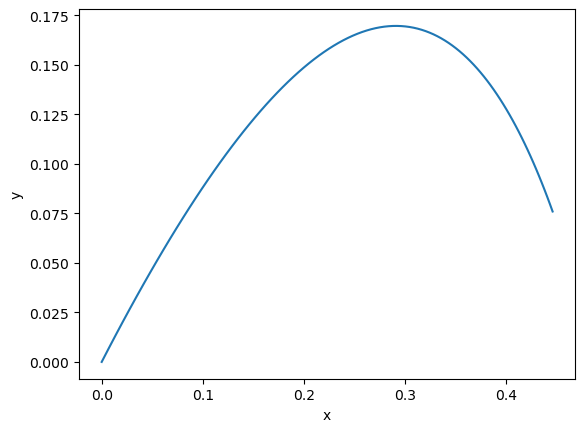

In [8]:
# The unsqueeze here are for two reasons:
# 1) We've decided that even scalar inputs need to have a shape of (1,)
# 2) Our batch shape is (1,)
# So the shape of times should be (ntime,1,1)
times = torch.linspace(0, stop_time, ntime).unsqueeze(-1).unsqueeze(-1)
# Run the model
with torch.no_grad():
    first_result = model(times)
plt.plot(first_result[:, 0, 0].detach(), first_result[:, 0, 1].detach())
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Simulating more trajectories

Okay, now let's generate some "data" to use in training the model.  We'll define a normal distribution for the launch angles, launch velocity, and constant "c" defining the wind resistance.  We can change the shape of the model parameters and the input times to quickly sample a whole bunch of trajectories, after first sample the parameters.

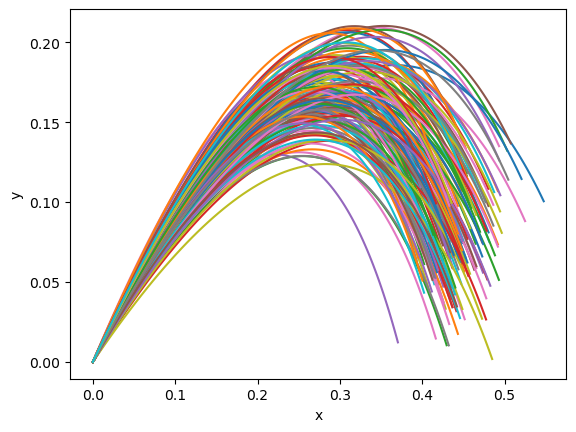

In [9]:
# Number of samples we want to generate
nsamples = 150

# Normal distribution parameters
c_loc = 1.0
c_scale = c_loc / 20.0
theta0_loc = torch.pi / 4
theta0_scale = theta0_loc / 20.0
v0_loc = 1.0
v0_scale = v0_loc / 20.0

# Actually sample the parameters
model.discrete_equations.ode.c.data = torch.normal(c_loc, c_scale, (nsamples,1))
model.discrete_equations.ode.theta0.data = torch.normal(theta0_loc, theta0_scale, (nsamples,1))
model.discrete_equations.ode.v0.data = torch.normal(v0_loc, v0_scale, (nsamples,1))

# We need times consistent with the batch size
times = torch.linspace(0, stop_time, ntime).unsqueeze(-1).unsqueeze(-1).expand((ntime, nsamples, 1))

# Go ahead and sample
with torch.no_grad():
    data_results = model(times)

plt.plot(data_results[..., 0].detach(), data_results[..., 1].detach())
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Inference

That's a lot of trajectories!  Now let's do a test/train split and see if we can recover the average values of $v_0$, $\theta_0$, and $c$ just by observing some trajectories.  We can train our model just like a regular torch model, the only thing we'll do first is reset the parameter values to be scalars again.  We'll choose our initial values randomly from uniform distributions.

In [10]:
# Reset parameter values
model.discrete_equations.ode.c.data = torch.rand((1,)) + 0.5
model.discrete_equations.ode.theta0.data = torch.rand((1,)) * torch.pi/2.0
model.discrete_equations.ode.v0.data = torch.rand((1,)) * 2.0

# Keep these for later reference
original = {
    "c": model.discrete_equations.ode.c.data.clone()[0],
    "theta0": model.discrete_equations.ode.theta0.data.clone()[0],
    "v0": model.discrete_equations.ode.v0.data.clone()[0]
}

model.zero_grad()

# Select our training data, our conditions are already random so...
ntrain = int(0.9 * nsamples)
train = data_results[:,:ntrain]
test = data_results[:,ntrain:]

# Define the times over which to integrate
times = (
    torch.linspace(0, stop_time, ntime)
    .unsqueeze(-1)
    .unsqueeze(-1)
    .expand((ntime, nsamples, 1))
)

# For future visualization, save the initial predicted trajectory
with torch.no_grad():
    orig_traj = model(times)

### Now let's learn!
Everything else looks pretty standard.  Define an optimizer, a loss function, and some hyperparameters and go to town!

Loss: 5.06e-04: : 100%|██████████|1000/1000


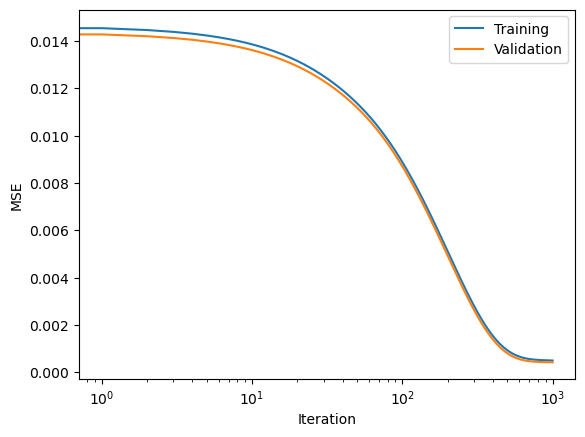

In [11]:
niter = 1000
lr = 1.0e-3
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_fn = torch.nn.MSELoss()


titer = tqdm.tqdm(
    range(niter),
    bar_format="{desc}: {percentage:3.0f}%|{bar}|{n_fmt}/{total_fmt}{postfix}",
)
titer.set_description("Loss:")
loss_history = []
val_loss = []
for i in titer:
    optimizer.zero_grad()
    res = model(times)
    loss = loss_fn(res[:,:ntrain], train)
    loss.backward()
    loss_history.append(loss.item())
    val_loss.append(loss_fn(res[:,ntrain:], test).item())
    titer.set_description("Loss: %3.2e" % loss_history[-1])
    optimizer.step()

plt.semilogx(loss_history, label = "Training")
plt.semilogx(val_loss, label = "Validation")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend(loc='best')
plt.show()

## Alright, let's see how we did!

Notice that while the parameters are somewhat different from the true values the average model prediction for the trajectory falls in the middle of the data.  This wouldn't be a problem if you were just going to predict new trajectories.  Later examples show statistical learning can provide both accurate predictions and better estimations of the true parameters.

Var	Orig.	Pred.	True
c	1.45	1.67	1.00
v0	1.07	1.17	1.00
theta0	0.32	0.74	0.79


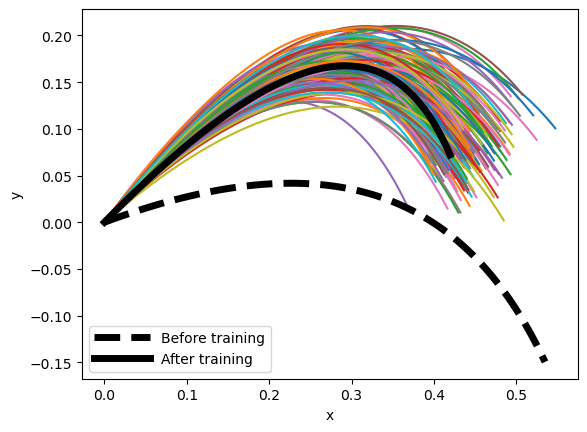

In [12]:
results = {"c": (model.discrete_equations.ode.c.data[0], c_loc), "v0": (model.discrete_equations.ode.v0.data[0], v0_loc), "theta0": (model.discrete_equations.ode.theta0.data[0], theta0_loc)}
print("Var\tOrig.\tPred.\tTrue")
for name, (pred,true) in results.items():
    print("%s\t%3.2f\t%3.2f\t%3.2f" % (name, original[name], pred, true))

plt.plot(data_results[..., 0].detach(), data_results[..., 1].detach())
plt.plot(orig_traj[:,0,0], orig_traj[:,0,1], color = 'k', lw = 5, ls = '--', label = "Before training")
plt.plot(res[:, 0, 0].detach(), res[:, 0, 1].detach(), color="k", lw=5, label = "After training")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='best', handlelength = 4)
plt.show()